# Programming Exercise: Positional Encoding in Transformers

**Duration:** 45 minutes
**Goals:** Implement sinusoidal positional encodings, visualize them, compare to learned embeddings, and study how they affect attention.

> Complete all TODOs and answer short prompts in the designated Markdown cells.

## Learning Objectives
By the end of this exercise, you will be able to:
1. Implement **sinusoidal positional encodings** from *Attention Is All You Need*.
2. Visualize how different embedding dimensions oscillate at different frequencies.
3. Explain how positional encodings provide **absolute** and **relative** position cues.
4. Compare **fixed (sinusoidal)** vs **learned** positional embeddings with a tiny experiment.
5. Observe how adding positional encodings changes **dot‑product attention** patterns.

In [2]:
# === Setup ===
import math
import numpy as np
import matplotlib.pyplot as plt

# IMPORTANT FOR THIS EXERCISE:
# - Use matplotlib only (no seaborn).
# - Keep each chart in its own figure (no subplots).
# - Do NOT set specific colors or styles unless asked.
np.set_printoptions(precision=4, suppress=True)

## Part 1 — Implement sinusoidal positional encodings (Required)

**Task:** Implement the function `sinusoidal_pe(max_len, d_model)` that returns a NumPy array of shape `(max_len, d_model)` using:

$$PE(pos, 2i) = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
$$PE(pos, 2i+1) = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

**Checklist:**
- Works for any `max_len ≥ 1` and `d_model ≥ 2`.
- Even dims use `sin`, odd dims use `cos`.
- Vectorized implementation (no slow Python loops over positions is preferred but not required).

In [3]:
def sinusoidal_pe(max_len: int, d_model: int) -> np.ndarray:
    """
    Compute sinusoidal positional encodings.
    Returns: array of shape (max_len, d_model)
    """
        # TODO: Implement per the formula above.
    # Hints:
    # - Create an array of positions shape (max_len, 1)
    positions = np.arange(max_len)[:, np.newaxis]

    # - Create a dim index array shape (1, d_model)
    dimensions = np.arange(d_model)[np.newaxis, :]

    # - Compute angle rates with 10000 ** (2 * (i//2) / d_model)
    angle_rates = 1 / (10000 ** (2 * (dimensions // 2) / d_model))
    angles = positions * angle_rates

    # - Apply sin to even columns, cos to odd columns
    pe = np.zeros((max_len, d_model))
    pe[:, 0::2] = np.sin(angles[:, 0::2])
    pe[:, 1::2] = np.cos(angles[:, 1::2])

    return pe

### Quick checks

Run the following cell after your implementation. It performs simple structural checks and prints a preview.

In [4]:
# === Sanity checks (do not modify) ===
def _quick_checks():
    pe = sinusoidal_pe(8, 6)
    assert pe.shape == (8, 6), 'Shape should be (max_len, d_model) == (8, 6)'
    # position 0 should be [0,1,0,1,...]
    row0 = pe[0]
    np.testing.assert_allclose(row0[0::2], np.zeros(3), atol=1e-7)
    np.testing.assert_allclose(row0[1::2], np.ones(3), atol=1e-7)
    print('Basic checks passed. Preview:\n', np.round(pe[:5], 4))

try:
    _quick_checks()
except NotImplementedError as e:
    print(e)

Basic checks passed. Preview:
 [[ 0.      1.      0.      1.      0.      1.    ]
 [ 0.8415  0.5403  0.0464  0.9989  0.0022  1.    ]
 [ 0.9093 -0.4161  0.0927  0.9957  0.0043  1.    ]
 [ 0.1411 -0.99    0.1388  0.9903  0.0065  1.    ]
 [-0.7568 -0.6536  0.1846  0.9828  0.0086  1.    ]]


## Part 2 — Visualize positional encodings (Required)

**Task:** Visualize the heatmap for `d_model = 6` and positions `0..49` using your function.

**Prompt:** In the Markdown cell below the plot, explain:
- Which dimensions oscillate fastest vs slowest?
- What does this imply for capturing local vs global position information?

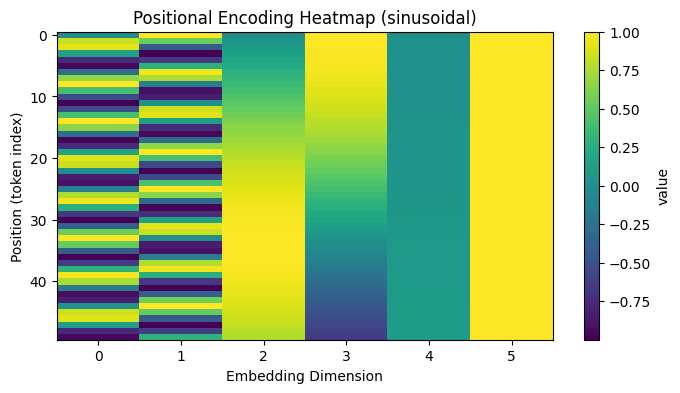

In [5]:
# === Your visualization ===
max_len = 50
d_model = 6
pe = sinusoidal_pe(max_len, d_model)

plt.figure(figsize=(8, 4))
plt.imshow(pe, aspect='auto')
plt.colorbar(label='value')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position (token index)')
plt.title('Positional Encoding Heatmap (sinusoidal)')
plt.show()

**Your explanation (2–4 sentences):**  
*Dimensions 0 and 1 appear to oscillate considerably more than the others based on the heatmap generated. They have a more drastic change in colors compared to the slow gradient of the others. The implication of this is that faster oscillations should be able to capture more detailed changes in local position.*

## Part 3 — Relative distance cue (Required)

**Task:** Show that **relative positions** are encoded:  
Pick two positions `p` and `q`, compute the cosine similarity between their encodings `PE[p]` and `PE[q]` **as a function of |p−q|**.

1. Write a function `pairwise_cosine(pe)` that returns a `(max_len, max_len)` matrix of cosine similarities.
2. Plot the matrix as an image for `max_len = 60, d_model = 32`.
3. In the Markdown cell: Describe the visible pattern (e.g., bands/diagonals) and connect it to relative distances.

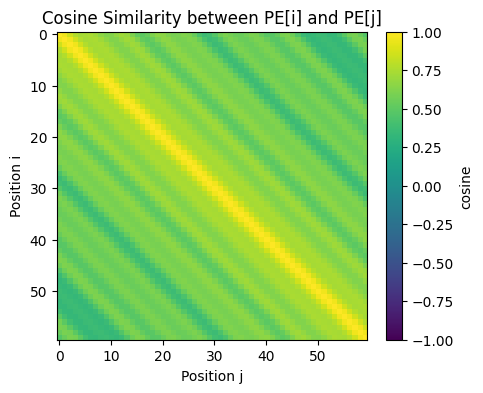

In [6]:
def pairwise_cosine(x: np.ndarray) -> np.ndarray:
    """
    Returns cosine-similarity matrix of x.
    x: (N, D)
    """
    # TODO: Implement cosine similarity using normalization and matrix multiply.

    x_norm = x / np.linalg.norm(x, axis=1, keepdims=True)
    return x_norm @ x_norm.T

# === Use your function ===
max_len = 60
d_model = 32
pe = sinusoidal_pe(max_len, d_model)

# Compute pairwise cosine similarities
C = pairwise_cosine(pe)

plt.figure(figsize=(5, 4))
plt.imshow(C, aspect='auto', vmin=-1.0, vmax=1.0)
plt.colorbar(label='cosine')
plt.xlabel('Position j')
plt.ylabel('Position i')
plt.title('Cosine Similarity between PE[i] and PE[j]')
plt.show()

**Your explanation (3–5 sentences):**  
*What is interesting about this figure is that we get diagonal bands. This would imply that the i and j positions correlate in their cosine similarity. This shows the concept of dot product with our positional encodings in how they relate to the cosine.*

## Part 4 — Learned vs Fixed Positional Embeddings (Optional but recommended)

We’ll do a toy extrapolation test: learn a linear regressor to predict a simple target from **position** only.

**Targets:**
- `y(pos) = sin(pos / 3) + 0.3 * cos(pos / 11)` (a mixture of waves).

**Train:** positions `0..39`.  
**Test:** positions `40..79` (out-of-range).

Compare two input representations:
1. **Fixed sinusoidal PE**: feed `PE[pos]` to the regressor.  
2. **One‑hot absolute position** (length = 40): feed one‑hot(pos) for training positions; at test time, zeros (cannot represent unseen positions).

**Expectations:** Sinusoidal features extrapolate; one‑hot cannot.

> Implement the experiment and plot train/test predictions. Use only `numpy` (no deep learning frameworks).

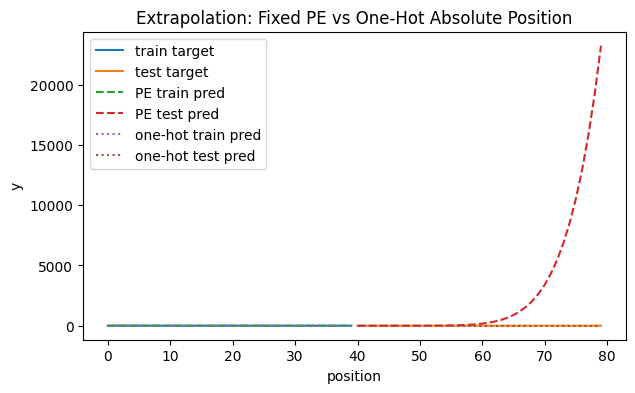

PE test RMSE:    6410.5704
One-hot RMSE:   0.7075   (expected to be large / degenerate)


In [7]:
# === Your small experiment ===

def make_targets(positions):
    return np.sin(positions / 3.0) + 0.3 * np.cos(positions / 11.0)

# Data
train_pos = np.arange(0, 40)
test_pos  = np.arange(40, 80)

# Inputs for model A: sinusoidal PE (use d_model=32 for richer features)
d_model = 32
PE_all = sinusoidal_pe(80, d_model)
X_train_A = PE_all[train_pos]
X_test_A  = PE_all[test_pos]

# Inputs for model B: one-hot absolute positions (length 40)
X_train_B = np.eye(40)[train_pos]
X_test_B  = np.zeros_like(np.eye(40)[:len(test_pos)])  # cannot represent unseen positions

y_train = make_targets(train_pos)
y_test  = make_targets(test_pos)

# Fit linear least squares: w = (X^T X)^(-1) X^T y
def fit_linear(X, y):
    return np.linalg.pinv(X) @ y

w_A = fit_linear(X_train_A, y_train)
w_B = fit_linear(X_train_B, y_train)

y_pred_A_train = X_train_A @ w_A
y_pred_A_test  = X_test_A  @ w_A

y_pred_B_train = X_train_B @ w_B
y_pred_B_test  = X_test_B  @ w_B

# Plot predictions
plt.figure(figsize=(7, 4))
plt.plot(train_pos, y_train, label='train target')
plt.plot(test_pos, y_test, label='test target')
plt.plot(train_pos, y_pred_A_train, linestyle='--', label='PE train pred')
plt.plot(test_pos, y_pred_A_test, linestyle='--', label='PE test pred')
plt.plot(train_pos, y_pred_B_train, linestyle=':', label='one-hot train pred')
plt.plot(test_pos, y_pred_B_test, linestyle=':', label='one-hot test pred')
plt.legend()
plt.title('Extrapolation: Fixed PE vs One‑Hot Absolute Position')
plt.xlabel('position')
plt.ylabel('y')
plt.show()

# Short numeric summary (optional)
from math import sqrt
rmse_A_test = sqrt(np.mean((y_pred_A_test - y_test)**2))
rmse_B_test = sqrt(np.mean((y_pred_B_test - y_test)**2))
print(f'PE test RMSE:    {rmse_A_test:.4f}')
print(f'One-hot RMSE:   {rmse_B_test:.4f}   (expected to be large / degenerate)')

## Part 5 — How PE changes attention (Required)

Consider a toy sequence of `L=12` tokens with base token embeddings all equal to zero (for isolation).  
We add positional encodings and compute a **self-attention score matrix** using simple **queries/keys** as linear projections of the PE.

**Task:**
1. Build `Q = PE @ Wq`, `K = PE @ Wk` with small random matrices `Wq, Wk` (seeded).
2. Compute raw scores `S = Q K^T / sqrt(d_k)` and visualize `S` (no softmax needed).
3. Repeat **without** positional encodings (i.e., zeros only). Compare.

**Prompt:** In the Markdown cell, explain what patterns you see and why PE is necessary for attention to distinguish positions.

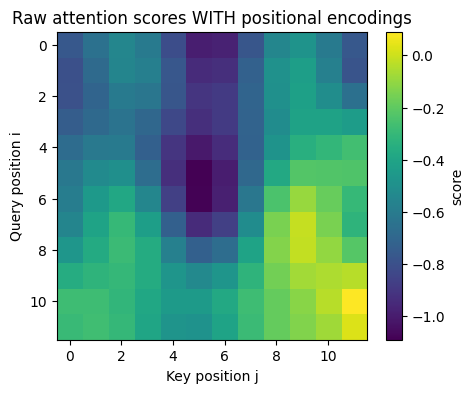

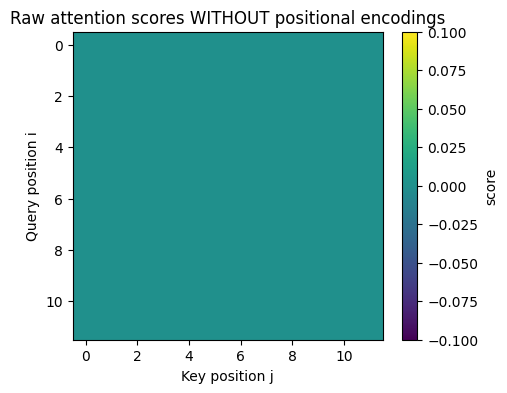

In [8]:
rng = np.random.default_rng(42)

L = 12
d_model = 32
d_k = 16

# with PE
PE = sinusoidal_pe(L, d_model)
Wq = rng.standard_normal((d_model, d_k)) / np.sqrt(d_model)
Wk = rng.standard_normal((d_model, d_k)) / np.sqrt(d_model)

Q = PE @ Wq
K = PE @ Wk
S_with = (Q @ K.T) / np.sqrt(d_k)

plt.figure(figsize=(5,4))
plt.imshow(S_with, aspect='auto')
plt.colorbar(label='score')
plt.title('Raw attention scores WITH positional encodings')
plt.xlabel('Key position j')
plt.ylabel('Query position i')
plt.show()

# without PE (all-zero embeddings)
X = np.zeros((L, d_model))
Q0 = X @ Wq
K0 = X @ Wk
S_without = (Q0 @ K0.T) / np.sqrt(d_k)

plt.figure(figsize=(5,4))
plt.imshow(S_without, aspect='auto')
plt.colorbar(label='score')
plt.title('Raw attention scores WITHOUT positional encodings')
plt.xlabel('Key position j')
plt.ylabel('Query position i')
plt.show()

**Your explanation (3–5 sentences):**  
*What these two figures show is the importance of positional encodings for attention. The second figure is functionally blank or uniform since to be able to get attention scores positional encodings is required for the figure to have any detail. Without positional encodings all the queries and keys from the same zero vector will be identical. This is why with positional encodings the first figure actually has detail and change in color.*

## Deliverables
- Completed code cells (no `NotImplementedError`).
- Three brief Markdown explanations (Parts 2, 3, and 5).
- The plot for the extrapolation experiment (Part 4) if you attempt it.

## Grading Rubric (suggested)
- Part 1 (Implementation): 35%
- Part 2 (Visualization + explanation): 15%
- Part 3 (Cosine matrix + explanation): 25%
- Part 5 (Attention effect + explanation): 25%
- (+5% extra credit) Part 4 extrapolation experiment

---

### Short-answer prompts you should be able to address
- Why mix **multiple frequencies** across dimensions?
- How do fixed sinusoidal encodings help with **extrapolation** to longer sequences?
- Why do attention scores collapse without positional information when token embeddings are identical?